<a id='Title-Regression'></a>
<h1 style="color:SlateGray;">Regression</h1>

**Input dataset**

Boston Housing: a set of housing prices and 13 associated house-rating data points.

**Output classification**

Predicts the price of a house.

<h2 style="color:SlateGray;">Background</h2>

**Layers**

[*Dense*](1_Image_Classification.ipynb#Layers-Dense)
		
**Activations**

[*relu*](1_Image_Classification.ipynb#Activations-relu)
		
**Optimizers**

[*rmsprop*](1_Image_Classification.ipynb#Optimizers-rmsprop)
		
**Loss functions**

<a id='Loss-functions-mse'></a>
*mse*

Measures the average squared difference between the estimated values and what is estimated.

Implemented as the function $\dfrac{1}{n} \sum^{n}_{i = 1} (\mathbf{Y}_i - \mathbf{ \hat{Y} }_i)^2$, where $\mathbf{ \hat{Y} }$ is the model's output prediction and $\mathbf{Y}$ is the input label.

<h2 style="color:SlateGray;">Overview</h2>

Classification using real-valued data with very few samples.

how does it do it?

Applies k-fold cross-validation on a 13-category data set. Each category in the training data $\mathbf{x}$ is normalized by $\dfrac{ \mathbf{x} - mean ( \mathbf{x} ) }{ std( \mathbf{x} ) }$ and each category in the test data $\mathbf{y}$ is similarly normalized by $\dfrac{ \mathbf{y} - mean ( \mathbf{x} ) }{ std( \mathbf{x} ) }$.

In [28]:
import keras
keras.__version__

'2.2.2'

In [29]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [30]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [31]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [32]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs,
              batch_size=1,
              verbose=0)

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [33]:
print(all_scores)
print(np.mean(all_scores))

[2.0956787838794217, 2.220593797098292, 2.859968412040484, 2.40535704039111]
2.3953995083523267


In [34]:
from keras import backend as K

K.clear_session()

In [35]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [37]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

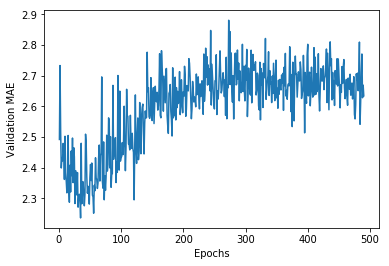

In [43]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

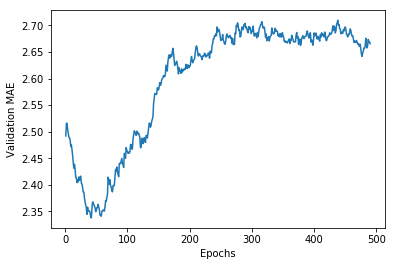

In [40]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [41]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 548us/step


In [42]:
test_mae_score

2.675027136709176